# Lecture 6.2 Programming a Deep Neural Network from Scratch with Python

## MNIST Data Set

The MNIST data set consists of 70,000 images of hand written digits, 60,000 of which are typically used as labeled training examples and the other 10,000 used for testing your learning model on. The following picture represent a sample of some of the images.

<img src="MnistExamples.png" alt="Drawing" style="width: 500px;"/>

We can load this dataset with the ```tensorflow.keras``` package. Load this data by running the following code.

---

In [1]:
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

(train_X, train_y), (test_X, test_y) = keras.datasets.mnist.load_data()

---

The data structures ```train_x``` and ```test_x``` are stored as 3 dimensional tensors. 
 
<img src="order-3-tensor.png" alt="Drawing" style="width: 300px;"/>

This can be varified by finding the shape of these variables. 

---

In [29]:
print(f"{np.shape(train_X) = }")
print(f"{np.shape(test_X) = } \n")

print(f"{np.shape(train_X[0]) = }")
print(f"{np.shape(test_X[0]) = } \n")

print(f"{train_X[0] = }")

np.shape(train_X) = (60000, 28, 28)
np.shape(test_X) = (10000, 28, 28) 

np.shape(train_X[0]) = (28, 28)
np.shape(test_X[0]) = (28, 28) 

train_X[0] = array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0. 

---

Each image is comprised of a $28\times 28$ grey scaled grid of pixel values. These values are floating point numbers in the interval $(0,1)$, where darker pixels will have values closer to $1$ and lighter pixels will have values closer to $0$. The following image represents one such example. 

<img src="MNIST-Matrix.png" alt="Drawing" style="width: 600px;"/>

We can view the image of one of these matrices by running the following code.

---

train_y[0] = 5 



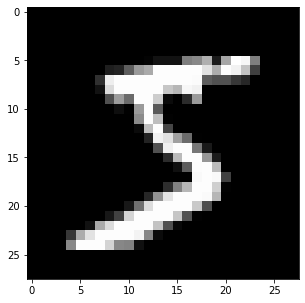

In [28]:
print(f"{train_y[0] = } \n")
plt.figure(figsize=(6, 5))
plt.imshow(train_X[0], cmap="gray")
plt.show()

---

## Image Flattening

Simple **dense neural networks** take as input feature vectors which are column vectors. In order to feed our images into such a network we must **flatten** the matrix into a column vector.

<img src="flatten.png" alt="Drawing" style="width: 500px;"/>

We can do this for each image matrix we are considering by calling the ```flatten()``` method together with the ```reshape(784, 1)``` method to insure it is a column vector. Note, that $784 = 28 \times 28$. By running the following code we reshape our images and store them in new variables. 

## One-Hot Encoding 

<img src="onehot.jpeg" alt="Drawing" style="width: 500px;"/>

---

In [2]:
# Scale the data for training. 
# train_X = train_X/255
# test_X = test_X/255

# Flatten the training images into coloumn vectors. 
X_train = []
for i, x in enumerate(train_X):
    X_train.append(x.flatten().reshape(784, 1))
    
# One hot encode the training labels
y_train = []
for label in train_y:
    temp_vec = np.zeros((10, 1))
    temp_vec[label][0] = 1.0
    y_train.append(temp_vec)


# Do the same for the testing data 
X_test = []
for i, x in enumerate(test_X):
    X_test.append(x.flatten().reshape(784, 1))
    
y_test = []
for label in test_y:
    temp_vec = np.zeros((10, 1))
    temp_vec[label] = 1.0
    y_test.append(temp_vec)
    

---

## Building the Network Architecture 
For our purposes, we will build a multilayered **fully connected**, or **dense**, neural network with $L$ layers, $784$ input notes, $L-2$ hidden layers of arbitrary size, and $10$ output nodes. 

<img src="multilayerPerceptron.jpg" alt="Drawing" style="width: 450px;"/>

For $\ell = 1, \dots, L$, each layer $\ell$ in our network will have two phases, the preactivation phase $$\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$$ and postactivation phase $$\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $\mathbf{a}^0 = \mathbf{x}^{(i)}$, where $\mathbf{x}^{(i)}$ is the current input data into our network. For our activation function, we will use the sigmoid function:

* Sigmoid Function
$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$

For our cost function, we will use the Mean Sqaure Error cost:
$$
C(W, b) = \frac{1}{2}\sum_{i=1}^{10}(a^{L}_i - y_i)^2.
$$

Our goal will be to write a custom Python class implementing our desired structure. However, before doing so, we first sequentually write functions to better understand the process of programming the following
* Initializing the layers weights and biases
* The feedforward phase
* Calculation of the cost function
* Calculation of the gradient
* Iterating stochastic gradient descent

---

In [3]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(10))[0]

In [4]:
def initialize_weights(layers = [784, 60, 60, 10]):
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

In [5]:
def deltas(W, B, yi, depth):
    Z, A = forward_pass(W, B, yi, depth)
    L = depth
    delta = dict()
    delta[L] = (A[-1] - yi)*d_sigmoid(Z[-1])
    for i in range(L-1, 1, -1):
        delta[i] = (delta[i+1]@W[i].T)*d_sigmoid(Z[-1])
    
    return A, delta

In [6]:
def forward_pass(W, B, xi, depth, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    for i in range(1, depth):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi, depth):
    _, A = forward_pass(W, B, xi, depth)
    return np.argmax(A[-1])

def random_experiment(W, B, data_features, data_labels):
    i = np.random.randint(len(data_features))
    print(f"Actual label: {np.argmax(data_labels[i])}")
    print(f"Predicted label: {predict(W, B, x, len(B))}")
    

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, len(W), predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

In [7]:
W, B = initialize_weights(layers = [784, 60, 60, 10])
print(f"Initial Cost = {MSE(W, B, X_train, y_train)}")

Initial Cost = 1.9354452766677352


predicted digit is: 2
actual digit is: 0


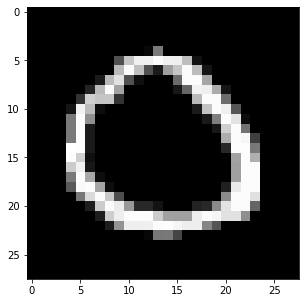

In [8]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()

In [19]:
#W, B = initialize_weights(layers = [784, 60, 60, 10])
def train(W, B, X_train, y_train, alpha = 0.046, epochs = 4):

    L = np.shape(W)[0]
    print(f"Starting Cost = {MSE(W, B, X_train, y_train)}")
    sample_size = len(X_train)
    L = len(W)
    for k in range(epochs):
        for xi, yi in zip(X_train, y_train):

            Z = [[0.0]]
            A = [xi]

            for i in range(1, L):
                z = W[i]@A[i-1] + B[i]
                a = sigmoid(z)
        
                Z.append(z)
                A.append(a)
        
            deltas = dict()
            delta_last = (A[L-1] - yi)*d_sigmoid(Z[L-1])
            deltas[L-1] = delta_last
            for i in range(L-2, 0, -1):
                deltas[i] = (W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])
            for i in range(1, L):
                W[i] -= alpha*deltas[i] @ A[i-1].T
                B[i] -= alpha*deltas[i]    


        print(f"{k}-th Cost = {MSE(W, B, X_train, y_train)}")


In [20]:
W, B = initialize_weights(layers = [784, 60, 60, 10])
train(W, B, X_train, y_train)

Starting Cost = 1.2631375892721945
0-th Cost = 0.07233847148790454
1-th Cost = 0.05127657969323812
2-th Cost = 0.041252253372467254
3-th Cost = 0.03496681219478937


predicted digit is: 2
actual digit is: 2


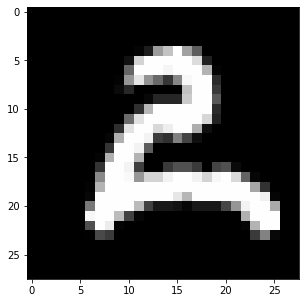

In [12]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 3
actual digit is: 3


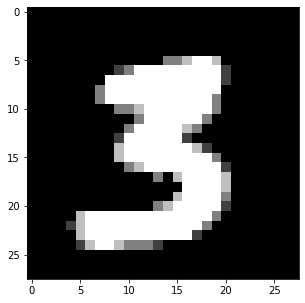

In [33]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 2
actual digit is: 7


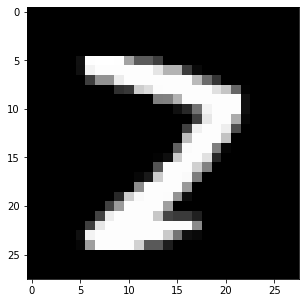

In [34]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 6
actual digit is: 6


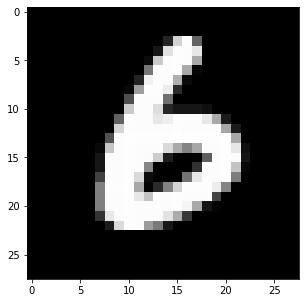

In [35]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 5
actual digit is: 5


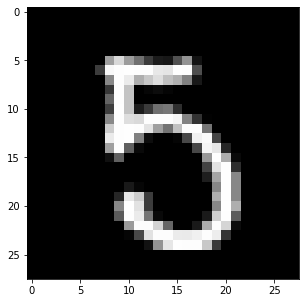

In [36]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 0
actual digit is: 0


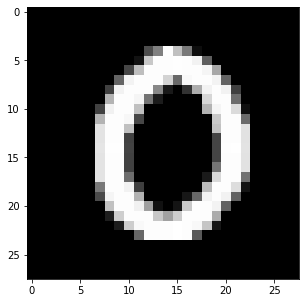

In [37]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 5
actual digit is: 5


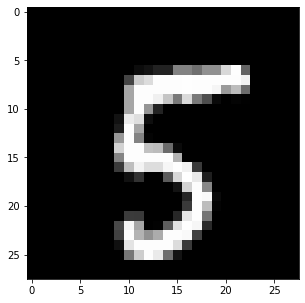

In [38]:
i = np.random.randint(0, len(X_test))
prediction = predict(W, B, X_test[i], len(B))
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(y_test[i])}")
plt.figure(figsize=(6, 5))
plt.imshow(test_X[i], cmap="gray")
plt.show()